## Sonification - Direct Audification
This notebook will be used for processing of one week of geomagnetic data, using CSV files downloaded from the VirES client.

In [26]:
# Import packages
import numpy as np
import scipy.signal as signal # DSP Toolbox
import scipy.io.wavfile as wav # WAV-file I/O
import matplotlib.pyplot as plt # plotting
import pandas as pd # CSV-file handling
import IPython.display as ipd # Embedded audio player in notebook
import resampy # anti-aliasing resampling
import pyrubberband as pyrb # time-streching and frequency shifting

# Set plots to dark mode
plt.style.use('dark_background')

In [33]:
# Load CSV-file with the geomagnetic data
#data = pd.read_csv('./VirES/SW_OPER_FACATMS_2F_SW_OPER_MAGA_LR_1B_SW_OPER_IPDAIRR_2F_20150201T000000_20150207T235958_Filtered.csv')
data = pd.read_csv('./VirES/Quiet-day-A-B.csv')
data = data.loc[data['Spacecraft'] == 'A']
data

Spacecraft                    Timestamp   Latitude   Longitude  \
0               A  2015-02-01T00:00:00.500000Z  79.271585  160.371620   
1               A  2015-02-01T00:00:01.500000Z  79.209429  160.452370   
2               A  2015-02-01T00:00:02.500000Z  79.147250  160.532159   
3               A  2015-02-01T00:00:03.500000Z  79.085048  160.611003   
4               A  2015-02-01T00:00:04.500000Z  79.022824  160.688916   
...           ...                          ...        ...         ...   
604795          A  2015-02-07T23:59:55.500000Z -84.839281  -45.694594   
604796          A  2015-02-07T23:59:56.500000Z -84.784438  -45.338677   
604797          A  2015-02-07T23:59:57.500000Z -84.729394  -44.990247   
604798          A  2015-02-07T23:59:58.500000Z -84.674156  -44.649099   
604799          A  2015-02-07T23:59:59.500000Z -84.618730  -44.315032   

            Radius           F       FAC        Ne          Viy          Viz  
0       6824837.96  47604.3388  1.005117  136802.1  4376.473140 -1120.812740  
1       6824840.96  47604.3808 -0.221692  102258.1  4583.783690 -1088.563960  
2       6824843.98  47604.3703  0.705464  103383.5  4279.056640  -961.618713  
3       6824847.03  47604.2540  0.771301   99686.2  3763.188960  -838.528564  
4       6824850.09  47603.9720 -2.979316   94026.1  3794.583500  -933.645264  
...            ...         ...       ...       ...          ...          ...  
604795  6844158.16  41006.2283 -0.048468  172603.4   495.280670  -887.606567  
604796  6844157.79  40968.4716  0.113586  164373.5   473.837250  -897.188721  
604797  6844157.42  40930.6760  0.034487  166681.9   266.995422  -876.331055  
604798  6844157.04  40892.8461  0.082259  163567.8   245.886459  -853.106201  
604799  6844156.66  40855.0304 -0.113752  160097.6   144.812302  -900.171265  

[604800 rows x 10 columns]

In [16]:
# Get the magnitude data and plot for confirmation
magnitude = data.get("Ne")
magnitude = magnitude.values
magnitude[np.isnan(magnitude)] = 0
print(magnitude)
plt.plot(magnitude)
plt.grid()
plt.show()

[136802.1 102258.1 103383.5 ... 164373.5 166681.9 163567.8]


In [4]:
# Extract the sampling rate
time = data.loc[0:1].get("Timestamp")

timeNative = []

for index in time:
    tmp = pd.to_datetime(index, format='%Y-%m-%dT%H:%M:%S') # convert to a Timestamp object
    timeNative.append(tmp.timestamp())                      # convert to POSIX timestamp

fs = (timeNative[1] - timeNative[0])**-1

print(f'Sampling Frequency: {fs}Hz')

Sampling Frequency: 1.0Hz


## Signal Processing

Minimum value of the magnitude: -853.270076 [nT] 
Maximum value of the magnitude: 957.664489 [nT]

Offset value: 0.0017965846814875675
Old peak-to-peak value: 1810.935
New peak-to-peak value: 1.000


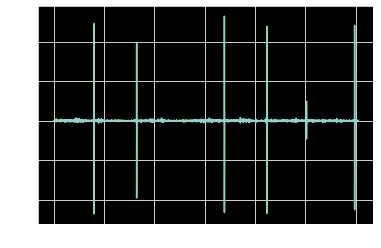

In [5]:
# Convert magnitude data into normalized +1/-1 floating point range
magMax = magnitude.max()
magMin = magnitude.min()
print(f'Minimum value of the magnitude: {magMin} [nT] \nMaximum value of the magnitude: {magMax} [nT]\n')

# remove DC/average
magDC = np.nanmean(magnitude)
magOffsetRemoved = magnitude - magDC
print(f'Offset value: {magDC}')

# calculate peak-to-peak and normalize
ptp = (magMax-magMin)
magScaled = magOffsetRemoved / ptp
ptpScaled = magScaled.max() - magScaled.min()
print(f'Old peak-to-peak value: {ptp:.3f}\nNew peak-to-peak value: {ptpScaled:.3f}')

# plot the normalized signal
plt.plot(magScaled)
plt.grid()

## Look at the frequency content of the signal

In [6]:
f, t, Sxx = signal.spectrogram(magScaled, fs, mode='magnitude', nperseg=2**12)
plt.pcolormesh(t, f, Sxx[:], shading='gouraud', cmap='hot')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,0.00125)
plt.show()

### Create a Butterworth highpass filter to remove the DC offset

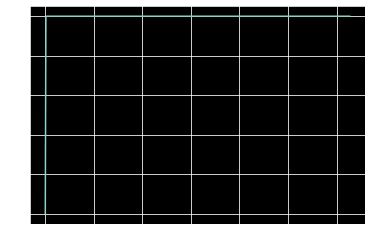

In [7]:
### Create a Butterworth highpass filter to remove the DC offset
N = 8 # filter order
fc = 0.0001 # cutoff frequency
sos = signal.butter(N, fc, 'highpass', fs=fs, output='sos')
w, h = signal.sosfreqz(sos)
plt.plot(w, abs(h))
plt.grid()

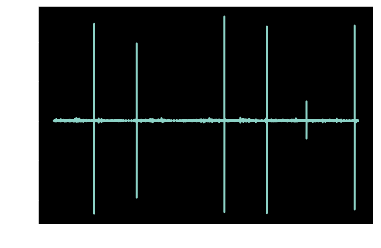

In [8]:
# filter the normalized magnitude signal
y = signal.sosfilt(sos, magScaled)
plt.plot(y)
plt.show()

f, t, Sxx = signal.spectrogram(y, fs, mode='magnitude', nperseg=2**12)
plt.pcolormesh(t, f, Sxx[:], shading='gouraud', cmap='hot')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,0.00125)
# plt.ylim(0,0.00125)
plt.show()

### Resample the original signal

New length in seconds: 1.9591836734693877s


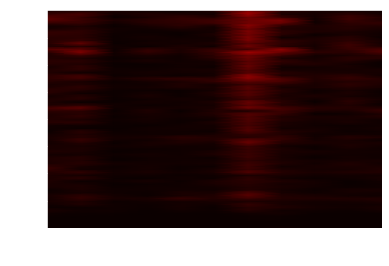

In [9]:
### METHOD 1 ###
"""
fs_new = 44100
T_length_original = len(y) / fs
T_length_resampled = 2
y_resampled = signal.resample(y, int(T_length_resampled*fs_new))

print(f'Total length of original signal in seconds: {T_length_original}s')
print(f'Total length of the resampled signal in seconds: {T_length_resampled}s')

ratio_fs = fs_new / fs
print(f'Ratio between the new and the old sampling frequency: {ratio_fs}')

ratio_samples = len(y_resampled) / len(y)
print(f'Ratio between the new and the old length (in samples): {ratio_samples}')

print(f'Frequency shifting scaling factor: {ratio_fs / ratio_samples}')
"""
### ### ###

### METHOD 2 ###

fs_new = 44100
resampling_factor = 7

y_resampled = resampy.resample(y,fs_new,int(fs_new/resampling_factor))

T_length_new = len(y_resampled) / fs_new

print(f'New length in seconds: {T_length_new}s')

### ### ###

### Create smoothing window to avoid clicks and pops in the start and end of the signal ###
window = np.ones(len(y_resampled))
t_fade = 0.1 # fade in/out in seconds
L = int(t_fade * fs_new)
fade = np.linspace(0,1,L)    

for i in range(L):
    window[i] *= fade[i]
    window[len(window)-1-i] *= fade[i]

y_resampled *= window

# plot spectrogram
f, t, Sxx = signal.spectrogram(y_resampled, fs_new, mode='magnitude', nperseg=2**(16+1-(int(1/2+resampling_factor/2))))
plt.pcolormesh(t, f, Sxx[:], shading='gouraud', cmap='hot')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.ylim(0,0.00125*fs_new*resampling_factor*2)
plt.ylim(0,400)
plt.show()

# play audio in notebook
ipd.Audio(y_resampled, rate=fs_new)

## Time Stretching

In [10]:
# time stretch signal
T_length_TS = 10 # length in seconds after time-stretching
TS_ratio = T_length_new / T_length_TS

y_timestretch = pyrb.time_stretch(y_resampled, fs_new, TS_ratio);

## Pitch Shifting

In [11]:
# pitch shifting of signal
octaves = 0
y_pitchshift = pyrb.pitch_shift(y_timestretch, fs_new, 12*octaves)

## Take a look at the spectrogram & listen

In [12]:
# plot spectrogram
f, t, Sxx = signal.spectrogram(y_pitchshift, fs_new, mode='magnitude', nperseg=2**14)
plt.pcolormesh(t, f, Sxx[:], shading='gouraud', cmap='hot')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0,400*(octaves+1))
plt.show()

# listen
ipd.Audio(y_pitchshift, rate=fs_new)

In [13]:
# Save as wav file
save = False
if save:
    wav_format = np.int16
    wav_amp_scaling = np.iinfo(wav_format).max
    data = wav_amp_scaling*y_pitchshift
    wav.write("audio_render/test.wav", fs_new, data.astype(wav_format))
    print(f'Wav-file saved')
else:
    print(f'Wav-file not saved')

Wav-file not saved
